In [93]:
import sys, os
ROOT = os.path.abspath(os.curdir)
sys.path.append(os.path.abspath(os.path.join(ROOT,'src')))
# SET VALUES TO MATCH EXPERIMENT
LOAD_DIR = os.path.join(ROOT,'results')

import irl_maxent.gridworld as W
# import irl_maxent.maxent as M
import irl_maxent.plot as P
# import irl_maxent.gridworld as W
# import irl_maxent.optimizer as O
import irl_maxent.solver as S
# import irl_maxent.optimizer as O

# import bi_irl.bi_maxent as M
# import bi_irl.helpers as H

import mix_irl.irleed as I
import mix_irl.helpers as H
import mix_irl.irl as IRL

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product       

import pickle
from tqdm import trange

Figure Settings 

In [94]:
ORANGE = '#FF9132'
RED   = '#B02105'
PINK = '#E600BF'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 3
FIG_HEIGHT = 3.5
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})
# global style for plots
style = {                                   
    'border': {'color': 'black', 'linewidth': 0.5},
    # 'border': None
}

options = {}
# configure options
options['discount'] = 0.9
options['horizon'] = 100
options['n_e_traj'] = 100 # eval
options['n_s_traj'] = 100 # sample
options['env_id'] = 1
options['debug'] = False
options['max_steps'] = 2
options['causal'] = False
options['ratios'] = [0.2]*5
options['n_traj'] = 200
options['lr_epsilons'] = 0.2
options['lr_theta'] = 0.2
options['lr_betas'] = 0.1

legend_key = ['Dem.',
              'IRL', 
              'IRLEED',
              ]
color_key = [GRAY,
             ORANGE, 
             GREEN,
            ]       

## Gridworld

In [95]:
from tqdm import trange
betas = [0.4,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
betas = np.array(betas)
lams = [2,2.5,3,3.5,4,4.5,5,5.5,6,10,100]
lams = np.array(lams)

results = np.zeros((len(betas),len(lams),3))
feature_exp = np.zeros((len(betas),len(lams),49))
thetas = np.zeros((len(betas),len(lams),2,49))
n_seeds = np.zeros((len(betas),len(lams),1))

for i_beta in range(len(betas)):
    beta = betas[i_beta]
    for i_lam in range(len(lams)):
        lam = lams[i_lam]
        # LOAD
        result_path = LOAD_DIR+'/gridworld/irleed/env_1/%.3f/lam_%.3f.p'%(beta,lam)
        options, data = pickle.load(open(result_path,'rb'))
        # FETCH
        returns = np.zeros(3)
        features = np.zeros(49)
        theta = np.zeros((2,49))
        count = 0
        # PROCESSS
        for dat in data:
            if dat is not None:
                # RETURNS
                # demonstrator
                returns[0] += dat['dem_rews']
                # irl
                returns[1] += dat['log']['rewards'][0]
                # irleed
                returns[2] += dat['log']['rewards'][1]
                scales = np.array(dat['mix_e_features']).max(axis=1)
                features += ((np.array(dat['mix_e_features']).T/scales).T).mean(axis=0)
                count += 1
                # rewards
                theta[0] += dat['log']['theta'][0]
                theta[1] += dat['log']['theta'][-1]
        # SAVE
        n_seeds[i_beta,i_lam] = count
        feature_exp[i_beta,i_lam] = features/count
        results[i_beta,i_lam] = returns/count
        thetas[i_beta,i_lam] = theta/count

In [96]:
# SET RESULTS ONECE
# HARD SET TO ZERO
beta_min=0
lam_min=0
#---------------------------------------------------#
dem_rew = results[beta_min:,lam_min:,0]
irl_rew = results[beta_min:,lam_min:,1]
irleed_rew = results[beta_min:,lam_min:,2]

i = 6
print(irleed_rew[i,:])
print(results[i,:])

[0.19131313 0.4276     0.5707     0.7571     0.7944     0.8747
 0.9248     0.9543     0.9729     0.9957     1.        ]
[[0.8579798  0.14666667 0.19131313]
 [0.9116     0.2474     0.4276    ]
 [0.9324     0.3203     0.5707    ]
 [0.951      0.5111     0.7571    ]
 [0.95735    0.5574     0.7944    ]
 [0.96295    0.6593     0.8747    ]
 [0.97265    0.7636     0.9248    ]
 [0.97035    0.7945     0.9543    ]
 [0.9767     0.8361     0.9729    ]
 [0.9857     0.981      0.9957    ]
 [0.9862     1.         1.        ]]


First we generate Figure 3 from the report. 

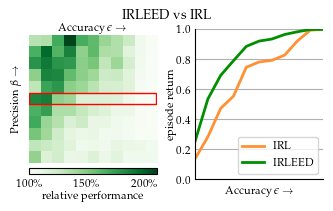

In [97]:
from matplotlib.patches import Rectangle 
import matplotlib.colors as mcolors

col_key = ['Relative Improvement',
           'Episode Return']
title = 'IRL vs IRLEED'
fig_name = 'IRL_vs_IRLEED'

# heatmap
heatmap = (irleed_rew/irl_rew)*100

fig = plt.figure(figsize=(3.2,2))
# fig = plt.figure(figsize=(5,4))
heights = np.ones(1)/1
widths = np.ones(2)/2

# spec.update(wspace=0.2, hspace=0)
spec = fig.add_gridspec(ncols=len(widths), 
                        nrows=len(heights), 
                        width_ratios=widths,
                        height_ratios=heights,
                        left=0.07,
                        right=0.99,
                        top=0.88,
                        bottom=0.13)

spec.update(wspace=0.3, hspace=0)
axs = [[fig.add_subplot(spec[row,col]) for col in range(len(widths))] for row in range(len(heights))]
fig.suptitle('IRLEED vs IRL')

## HEATMAP
ax_heat = axs[0][0]
# ax_heat.set_title(col_key[0])
divider = make_axes_locatable(ax_heat)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
p = ax_heat.imshow(heatmap, origin='lower',vmin=100,cmap='Greens')
cbar = fig.colorbar(p, cax=cax, orientation='horizontal')
cbar.set_ticks([100,150,200])
cbar.set_ticklabels(["$100\\%$","$150\\%$","$200\\%$"])
cbar.ax.tick_params(size=0)
ax_heat.set_ylabel('Precision $\\beta \\rightarrow$',labelpad=2)
ax_heat.set_xlabel('Accuracy $\\epsilon \\rightarrow$',labelpad=3)
# cbar.set_label('relative performance',position='top')
cax.set_xlabel('relative performance',labelpad=0)
# AXES
ax_heat.set_xticks([])
ax_heat.set_yticks([])
ax_heat.xaxis.set_label_position('top') 
ax_heat.spines['left'].set_visible(False)
ax_heat.spines['bottom'].set_visible(False)


## RECTANGLE OUTLINE
i_beta=5
ax_heat.add_patch(Rectangle((-0.45,-0.5+i_beta),10.91, 1, fill=False, edgecolor='red', lw=1))

## REWARD
ax_rew = axs[0][1]
# ax_rew.set_title(col_key[1],pad=16)
for step in range(1,3):
        ax_rew.plot(np.arange(len(results[i_beta,:,step])),
                results[i_beta,:,step],
                color=color_key[step],
                label=legend_key[step])
        

        
ax_rew.legend()
ax_rew.set_ylabel('episode return',labelpad=0)
ax_rew.set_xlabel('Accuracy $\\epsilon \\rightarrow$')
ax_rew.set_xticks([])
ax_rew.tick_params(size=0)
ax_rew.grid(axis='y')
ax_rew.set_xlim(0,len(results[i_beta,:,step])-1)
ax_rew.set_ylim(0,1)

plt.savefig(os.path.join(f'{ROOT}/figures','%s.pdf'%fig_name))

In [98]:
# get overall performance
print(np.mean(heatmap-100))
print(np.mean(irleed_rew-irl_rew))

30.330283105122287
0.1319409633525336


In [99]:
def normalize(vec):
    a = min(vec)
    b = max(vec)
    return (vec-a)/(b-a)

Next we generate Figure 2 from the report. 

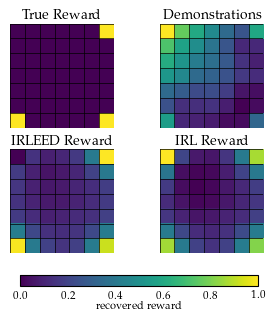

In [100]:
from matplotlib.patches import Rectangle 

fig_name = 'IRL_vs_IRLEED_rec_small'
i_beta = 8
i_lam = 7

fig = plt.figure(figsize=(3.2,3.2))
cbar_h = 0.05
heights = [(1-cbar_h)/2,(1-cbar_h)/2,cbar_h]
widths = np.ones(2)/2

spec = fig.add_gridspec(ncols=len(widths), 
                        nrows=len(heights), 
                        width_ratios=widths,
                        height_ratios=heights,
                        left=0.05,
                        right=0.98,
                        top=0.92,
                        bottom=0.1)

spec.update(wspace=0.01, hspace=0.3)

world, true_reward, terminal, initial = H.setup_mdp(setting=1)
## True Reward
ax_true = fig.add_subplot(spec[0,0])
p = P.plot_state_values(ax_true, world, true_reward, **style, vmin=0,vmax=1)
ax_true.set_title('True Reward',pad=0)
ax_true.set_xticks([])
ax_true.set_yticks([])
ax_true.spines['left'].set_visible(False)
ax_true.spines['bottom'].set_visible(False)
## Dem Rew
ax_dem = fig.add_subplot(spec[0,1])
dem_rew = normalize(feature_exp[i_beta,i_lam])
p = P.plot_state_values(ax_dem, world, dem_rew, **style, vmin=0,vmax=1)
ax_dem.set_title('Demonstrations',pad=0)
ax_dem.set_xticks([])
ax_dem.set_yticks([])
ax_dem.spines['left'].set_visible(False)
ax_dem.spines['bottom'].set_visible(False)

## IRLEED Rew
ax_irleed = fig.add_subplot(spec[1,0])
irleed_plt = normalize(thetas[i_beta,i_lam,1])
p = P.plot_state_values(ax_irleed, world, irleed_plt, **style, vmin=0,vmax=1)
ax_irleed.set_title('IRLEED Reward',pad=0)
ax_irleed.set_xticks([])
ax_irleed.set_yticks([])
ax_irleed.spines['left'].set_visible(False)
ax_irleed.spines['bottom'].set_visible(False)

## IRL Rew
ax_irl = fig.add_subplot(spec[1,1])
irl_plt = normalize(thetas[i_beta,i_lam,0])
p = P.plot_state_values(ax_irl, world, irl_plt, **style, vmin=0,vmax=1)
ax_irl.set_title('IRL Reward',pad=0)
ax_irl.set_xticks([])
ax_irl.set_yticks([])
ax_irl.spines['left'].set_visible(False)
ax_irl.spines['bottom'].set_visible(False)


# COLORBAR
cax = fig.add_subplot(spec[2,:])
pos = cax.get_position()
cbar = fig.colorbar(p, cax=cax,orientation='horizontal',)
# cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cax.set_position([pos.x0+.1, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.set_label('recovered reward',labelpad=0)
plt.savefig(os.path.join(f'{ROOT}/figures','%s.pdf'%fig_name))

## Hopper

In [101]:
import pandas as pd

# Define the experiments and algorithms
exps = ['ABC', 'A', 'B', 'C']
algos = ['IQ', 'IRLEED']
data={}

for exp in exps:
    for algo in algos:
        filename = f'{LOAD_DIR}/hopper/{exp}_{algo}.csv' 
        try:
            # Read the CSV file
            df = pd.read_csv(filename)
            
            # Determine the column name for 'reward' based on the algorithm
            if algo == 'IRLEED':
                reward_col = '_content.switch_step: 0 - eval/episode_reward'
            else:  # algo == 'iq'
                reward_col = '_content.switch_step: 2000000 - eval/episode_reward'
            
            # Check if the required columns exist in the DataFrame
            if 'Step' in df.columns and reward_col in df.columns:
                # Select the required columns
                df = df[['Step', reward_col]]
                # Rename columns
                df.rename(columns={'Step': 'step', reward_col: 'reward'}, inplace=True)
                # processing
                if exp in ["C"]:
                    df = df[0:400:4]
                elif exp in ["B"]:
                    df = df[0:200:2]
                else:
                    df = df[0:100:1]
                # # Add columns for experiment and algorithm
                df = df.dropna()
                print(f"succesfully passed {len(df)}")
                data[f"{exp}_{algo}"] = df["reward"].to_numpy()
            else:
                print(f"Columns not found in {filename}")
        except FileNotFoundError:
            print(f"File {filename} not found.")

        
for key, val in data.items():
    print(key)
    print(val.shape)

succesfully passed 100
succesfully passed 100
succesfully passed 100
succesfully passed 100
succesfully passed 100
succesfully passed 100
succesfully passed 100
succesfully passed 100
ABC_IQ
(100,)
ABC_IRLEED
(100,)
A_IQ
(100,)
A_IRLEED
(100,)
B_IQ
(100,)
B_IRLEED
(100,)
C_IQ
(100,)
C_IRLEED
(100,)


In [102]:
ORANGE = '#FF9132'
RED   = '#B02105'
PINK = '#E600BF'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 3
FIG_HEIGHT = 3.5
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})
# global style for plots
style = {                                   
    'border': {'color': 'black', 'linewidth': 0.5},
    # 'border': None
}

legend_key = ['Dem.',
              'IRL', 
              'IRLEED',
              ]
color_key = [GRAY,
             ORANGE, 
             GREEN,
            ]       


Finally we generate Figure 4 from the report. 

  Experiment Algorithm  Max Original Reward  Max Smoothed Reward
0        ABC        IQ          2207.386666          1785.551056
1        ABC    IRLEED          2441.649479          2111.877808
2          A        IQ          2960.991447          2613.867661
3          A    IRLEED          3064.524764          2628.040481
4          B        IQ          2140.423434          1697.330822
5          B    IRLEED          2165.024152          1764.090651
6          C        IQ           998.781576           564.550153
7          C    IRLEED           671.402545           525.745784


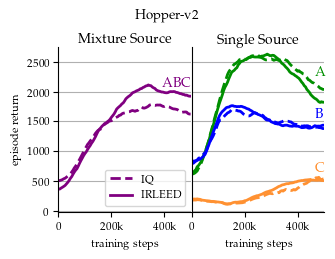

In [103]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for table creation
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

def smooth(y, box_pts):
    # Pad the data at both ends using reflection to reduce edge effects
    pad_width = box_pts // 2
    y_padded = np.pad(y, pad_width, mode='reflect')
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y_padded, box, mode='valid')
    return y_smooth

smooth_n = 30

title = 'Hopper-v2'  # Updated title
fig_name = 'hopper'
exps = ['ABC', 'A', 'B', 'C']
algos = ['IQ', 'IRLEED']

# Define color mapping for experiments
exp_colors = {
    'A': '#008F00',
    'B': 'blue',
    'C': '#FF9132',
    'ABC': "purple"  # Changed color
}

# Define line style mapping for algorithms
algo_styles = {
    'IRLEED': 'solid',
    'IQ': 'dashed'
}

fig = plt.figure(figsize=(3.2, 2.5))
heights = np.ones(1) / 1
widths = np.ones(2) / 2

spec = fig.add_gridspec(
    ncols=len(widths),
    nrows=len(heights),
    width_ratios=widths,
    height_ratios=heights,
    left=0.16,
    right=0.99,
    top=0.83,
    bottom=0.17,
)

spec.update(wspace=0.01, hspace=0)  # Reduced wspace to bring plots closer
axs = [
    [fig.add_subplot(spec[row, col]) for col in range(len(widths))]
    for row in range(len(heights))
]
fig.suptitle(f"{title}")

# Initialize a list to hold table data
table_data = []

# Plot 'ABC' into left plot
for algo in algos:
    exp = 'ABC'
    key = f"{exp}_{algo}"
    reward = data[key]  # Assume reward is 1D array
    smoothed_reward = smooth(reward, box_pts=smooth_n)  # Apply smoothing
    color = exp_colors[exp]
    linestyle = algo_styles[algo]

    axs[0][0].plot(
        smoothed_reward,
        label=f"{algo}",
        color=color,
        linestyle=linestyle,
        linewidth=2,  # Increased line width
    )

    # Collect data for the table
    max_original_reward = np.max(reward)
    max_smoothed_reward = np.max(smoothed_reward)
    table_data.append({
        'Experiment': exp,
        'Algorithm': algo,
        'Max Original Reward': max_original_reward,
        'Max Smoothed Reward': max_smoothed_reward
    })

axs[0][0].set_title("Mixture Source", pad=-30)  # Updated title
axs[0][0].legend()
axs[0][0].grid(axis='y')

# Plot 'A', 'B', 'C' into right plot
for exp in ['A', 'B', 'C']:
    color = exp_colors[exp]
    for algo in algos:
        key = f"{exp}_{algo}"
        reward = data[key]  # Assume reward is 1D array
        smoothed_reward = smooth(reward, box_pts=smooth_n)  # Apply smoothing
        linestyle = algo_styles[algo]

        axs[0][1].plot(
            smoothed_reward,
            label=f"{exp} {algo}",
            color=color,
            linestyle=linestyle,
            linewidth=2,  # Increased line width
        )

        # Collect data for the table
        max_original_reward = np.max(reward)
        max_smoothed_reward = np.max(smoothed_reward)
        table_data.append({
            'Experiment': exp,
            'Algorithm': algo,
            'Max Original Reward': max_original_reward,
            'Max Smoothed Reward': max_smoothed_reward
        })

axs[0][1].set_title("Single Source", pad=-30)  # Updated title
# Removed the legend from the right plot
# axs[0][1].legend()
axs[0][1].grid(axis='y')

# Remove y-axis labels on the right plot and adjust ticks
axs[0][1].set_yticklabels([])
axs[0][1].tick_params(axis='y', which='both', length=0)

# Make the vertical range (y-limits) the same for both plots
y_min_left, y_max_left = axs[0][0].get_ylim()
y_min_right, y_max_right = axs[0][1].get_ylim()

y_min = min(y_min_left, y_min_right)
y_max = max(y_max_left, y_max_right)

axs[0][0].set_ylim(y_min, y_max)
axs[0][1].set_ylim(y_min, y_max)
axs[0][0].set_xlim(0, 100)
axs[0][1].set_xlim(0, 100)
axs[0][0].set_xticks([0, 40, 80])
axs[0][1].set_xticks([0, 40, 80])
axs[0][0].set_xticklabels(['0', '200k', '400k'])
axs[0][1].set_xticklabels(['0', '200k', '400k'])
axs[0][0].set_xlabel("training steps")
axs[0][1].set_xlabel("training steps")
axs[0][0].set_ylabel("episode return")

# Adjust the layout to bring plots closer together
fig.subplots_adjust(wspace=0.05)

# Add labels "A", "B", "C" on the right edge of the right plot
x_label_pos = 95  # Position labels near the right edge

for exp in ['A', 'B', 'C']:
    color = exp_colors[exp]
    y_values = []
    for algo in algos:
        reward = data[f"{exp}_{algo}"]
        smoothed_reward = smooth(reward, box_pts=smooth_n)
        y_values.append(smoothed_reward[-1])
    y_mean = np.mean(y_values)

    # Place the labels at the average y-value of the last point
    if exp == "A":
        extra = 200
    else:
        extra=0
    axs[0][1].text(
        x_label_pos-2, y_mean + 200 + extra,
        exp,
        color=color,
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='left'
    )

# Add label "ABC" on the left plot
exp = 'ABC'
color = exp_colors[exp]
y_values = []
for algo in algos:
    reward = data[f"{exp}_{algo}"]
    smoothed_reward = smooth(reward, box_pts=smooth_n)
    y_values.append(smoothed_reward[-1])
y_mean = np.mean(y_values)

axs[0][0].text(
    x_label_pos - 17, y_mean + 350,
    exp,
    color=color,
    fontsize=10,
    verticalalignment='center',
    horizontalalignment='left'
)

plt.savefig(os.path.join(f'{ROOT}/figures', f'{fig_name}.pdf'))

# Create a DataFrame from the table data
df = pd.DataFrame(table_data)

# Print the table
print(df)
